<a href="https://colab.research.google.com/github/Tj-dev-py/Machine-Learning-Projects/blob/main/Covid_19_Computer_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

In [1]:
# getting the zip file from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [2]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '/content/drive/MyDrive/Covid19-dataset/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '/content/drive/MyDrive/Covid19-dataset/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    shuffle=True,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


# Define Model

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# from tensorflow.keras.layers.experimental import preprocessing

# # data augmentation to reduce overfitting
# data_augmentation = keras.Sequential(
#     [
#      # Preprocessing
#      preprocessing.RandomFlip('horizontal_and_vertical'), # flip left-to-right
#      preprocessing.RandomContrast(0.5), # contrast change by up to 50%
#      preprocessing.RandomZoom(.1) # Zooms the image
      
#     ]

# )

In [5]:
ds_train

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [6]:
ds_valid

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [8]:
from keras.layers.experimental import preprocessing

In [9]:
model = keras.Sequential([
  # Standardization                      
  preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)), # give the input dimensions in the first layer
                                                              # [height, width, color channels(RGB)]

  # First Convolutional Block
  layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same'),
  layers.MaxPool2D(),

  # Second Convolutional Block
  layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
  layers.MaxPool2D(),

  # Third Convolutional Block
  layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
  layers.MaxPool2D(),
  layers.Dropout(.2),

  # Classifier head
  layers.Flatten(),

  layers.Dense(10, activation='relu'),
  layers.Dense(3, activation='softmax')

])

In [10]:
# set an EarlyStopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [11]:
# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Train Model

In [12]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
    verbose=0,
    callbacks=[stop_early]
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0

In [14]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
12,0.097691,0.976096,0.181128,0.939394
13,0.169032,0.952191,0.733974,0.863636
14,0.096089,0.976096,0.529519,0.909091
15,0.068457,0.984064,0.408290,0.893939
16,0.027670,0.992032,0.391839,0.939394


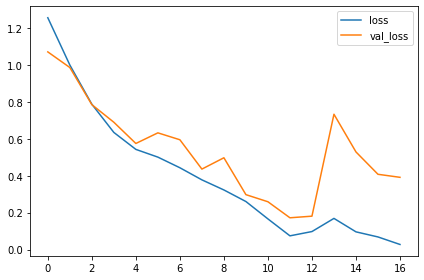

In [15]:
history_df[['loss', 'val_loss']].plot()

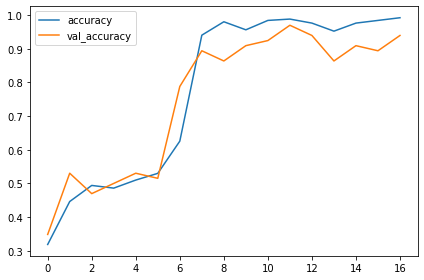

In [16]:
history_df[['accuracy', 'val_accuracy']].plot()